# Help Navigate Robots


这是一个有趣的训练机器人识别行驶路面类别的项目，它来自于 Kaggle 上的 [Help Navigate Robots](https://www.kaggle.com/c/career-con-2019)。
项目目的是通过在9 种行驶路面上，分别从10 个不同的传感器上收集了 方向、角速度、线性加速度的数据，来训练模型预测行驶路面类别，从而改善机器人的导航工作。
本文收集了一些好的想法，来观察并训练数据，其中一些特征提取方法并不代表是最优的。
需要强调的是，清晰的思路，科学的方法将会使问题变得简单。

### Import Modules

In [35]:
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


### Load Data

In [3]:
X_train = pd.read_csv('H:/kaggle/robots/career-con-2019/X_train.csv')
y_train = pd.read_csv('H:/kaggle/robots/career-con-2019/y_train.csv')
X_test = pd.read_csv('H:/kaggle/robots/career-con-2019/X_test.csv')

数据观察是非常重要的一个步骤，让我们一步一步来认识它。

**1、首先是训练集的样本数与特征：**

In [4]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
row_id                   487680 non-null object
series_id                487680 non-null int64
measurement_number       487680 non-null int64
orientation_X            487680 non-null float64
orientation_Y            487680 non-null float64
orientation_Z            487680 non-null float64
orientation_W            487680 non-null float64
angular_velocity_X       487680 non-null float64
angular_velocity_Y       487680 non-null float64
angular_velocity_Z       487680 non-null float64
linear_acceleration_X    487680 non-null float64
linear_acceleration_Y    487680 non-null float64
linear_acceleration_Z    487680 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB


In [6]:
X_train['series_id'].nunique()

3810

In [7]:
X_train['measurement_number'].nunique()

128

一共 487680 个样本，13个特征。<br>
根据项目介绍可了解到，其中 [0:3] 分别是 样本索引，样本系列ID，每个样本组的测量ID。<br>
剩下 [4:13] 这 10 个特征分别是10个传感器在不同时刻上收集的数据。
这些样本分为了 3810 个系列，每个系列包含了 128 次测量。可以推测到每一系列的数据应该是连续的时间内或者同一测试环境下的连续测量，后面可以观察到。<br>

**2、同样看下对应的标签集：**

In [8]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [9]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 3 columns):
series_id    3810 non-null int64
group_id     3810 non-null int64
surface      3810 non-null object
dtypes: int64(2), object(1)
memory usage: 89.4+ KB


In [10]:
y_train['surface'].values

array(['fine_concrete', 'concrete', 'concrete', ..., 'fine_concrete',
       'tiled', 'soft_pvc'], dtype=object)

In [11]:
y_train['group_id'].nunique()

73

除了相应的 3810 个系列标识 和 相应的标签栏 'surface'，还多了一个 group_id。<br>
项目说明中给出的解释为：
group_id: ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable more cross validation strategies.<br>
这里不太好理解，既然有了 serie_id，为什么还有 group_id。serie_id 和 group_id 又有什么联系呢？<br>
其实，从后半句翻译 "仅为培训集提供，以实现更多交叉验证策略" 中，不难理解 每个 group_id 对应一种路面类别，每个 group 应该是包含一些列 serie_id，提供这个字段的意义，就是为了训练模型在交叉验证中，使得训练集和验证集中每组的数据平衡，从而提高验证的准确性。

**3、最后剩下测试集，测试集和训练集结构一致，简单看下：**

In [12]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488448 entries, 0 to 488447
Data columns (total 13 columns):
row_id                   488448 non-null object
series_id                488448 non-null int64
measurement_number       488448 non-null int64
orientation_X            488448 non-null float64
orientation_Y            488448 non-null float64
orientation_Z            488448 non-null float64
orientation_W            488448 non-null float64
angular_velocity_X       488448 non-null float64
angular_velocity_Y       488448 non-null float64
angular_velocity_Z       488448 non-null float64
linear_acceleration_X    488448 non-null float64
linear_acceleration_Y    488448 non-null float64
linear_acceleration_Z    488448 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB


### Data Exploration

先创建一个数据副本，用于尝试。

In [13]:
train = X_train.copy()
target = y_train.copy()
test = X_test.copy()

1、**数据可视化**

既然是多分类问题，让我们先从总体上看下每个分类在每个特征下的概率分布情况。

In [14]:
classes = (target['surface'].value_counts()).index
features = train.columns.values[3:]
aux = train.merge(target, on='series_id', how='inner')

H:\Program Files\Anaconda3\envs\tensorflow_gpu\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


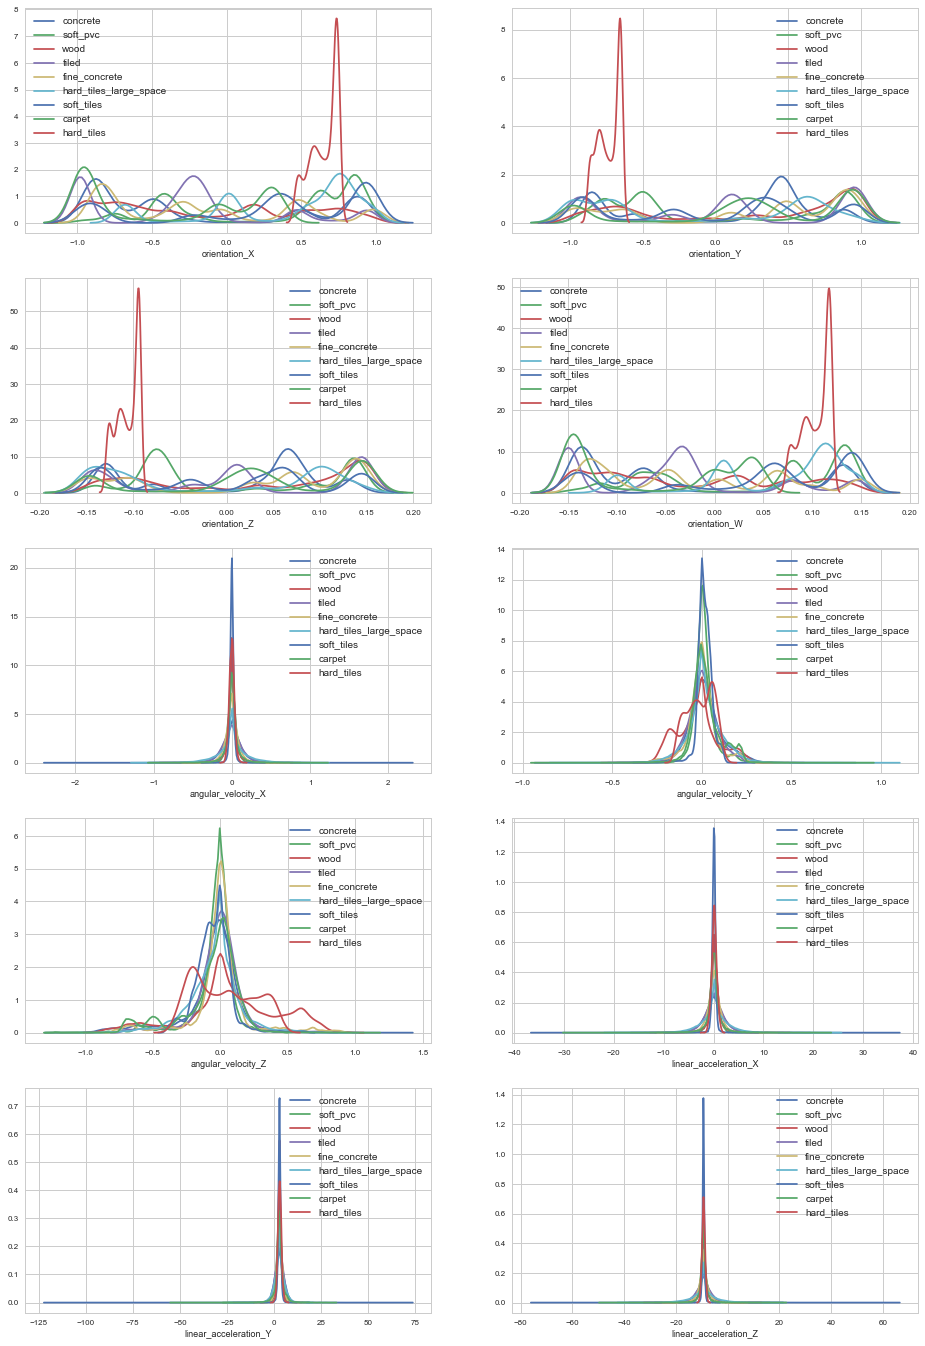

In [15]:
def plot_feature_class_distribution(classes,tt, features,a=5,b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature],label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show()
    
plot_feature_class_distribution(classes, aux, features)

可以看出
- 不同类别在不同特征上的概率分布差异还是比较明显的
- 大部分数据是遵从正太分布的
- 不同特征的坐标尺度存在较大差异

**2、观察下特征之间的相关性：**

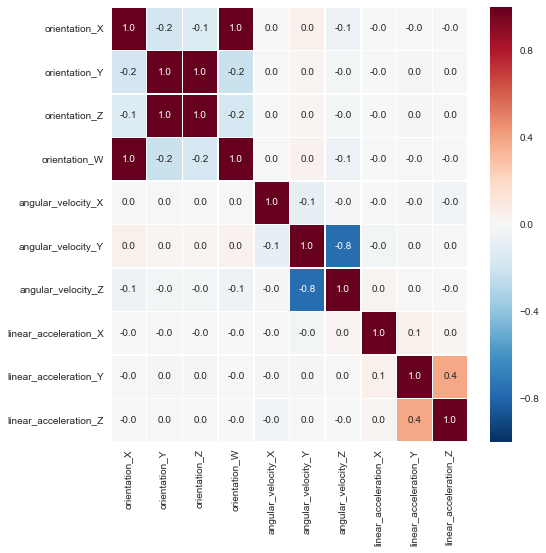

In [16]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(train.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

可以看到
- 方向 X 和 方向 W 有很强的正相关性，
- 方向 Y 和 方向 Z 有很强的正相关性，
- 角速度 Z 和 角速度 Y 有较强的负相关性。

**3、试验不同的组合**

我们可以增加些数学特征，比如，范数，模和每个方向在模上的比值。<br>

In [17]:
def feature_mathematical(data):    
    """
    增加 angular、linear、orientation 三个大特征的范数特征，
    增加 orientation 每个方向上的比例特征。
    """
    data['norm_angular'] = (data['angular_velocity_X']**2
                            + data['angular_velocity_Y']**2
                            + data['angular_velocity_Z']**2)** 0.5
    data['norm_linear'] = (data['linear_acceleration_X']**2 
                           + data['linear_acceleration_Y']**2 
                           + data['linear_acceleration_Z']**2)**0.5
    data['norm_orientation'] = (data['orientation_X']**2 
                                + data['orientation_Y']**2 
                                + data['orientation_Z']**2 
                                + data['orientation_W']**2)**0.5
    data['norm_X'] = data['orientation_X'] / data['norm_orientation']
    data['norm_Y'] = data['orientation_Y'] / data['norm_orientation']
    data['norm_Z'] = data['orientation_Z'] / data['norm_orientation']
    data['norm_W'] = data['orientation_W'] / data['norm_orientation']
    
    return data

In [18]:
train = feature_mathematical(train)
test = feature_mathematical(test)

我们还可以将四元数转换为欧拉角表示法，即：RPY角(Roll, Pitch, Yaw)。

In [19]:
def feature_eular(data):
    """
    增加欧拉角特征
    """
    data['roll'] = np.arctan2(2*(data['orientation_W']*data['orientation_X'] 
                              + data['orientation_Y']*data['orientation_Z']),
                              1 - 2*(data['orientation_X']*data['orientation_X'] 
                              + data['orientation_Y']*data['orientation_Y']))
    data['pitch'] = np.arcsin(2*(data['orientation_W']*data['orientation_Y'] 
                              - data['orientation_Z']*data['orientation_X']))
    data['yaw'] = np.arctan2(2*(data['orientation_W']*data['orientation_Z'] 
                             + data['orientation_X']*data['orientation_Y']),
                             1 - 2*(data['orientation_Y']*data['orientation_Y'] 
                             + data['orientation_Z']*data['orientation_Z']))
    return data

In [20]:
train = feature_eular(train)
test = feature_eular(test)

In [21]:
train.shape

(487680, 23)

### Date Merge

训练集的样本数是以 3810 个系列乘以 128 次测量，而标签集则是以系列为单位的，所以我们需要把样本集压缩到3810 个样本。这里有一个技巧是提取每个系列的128 个数据的综合特征。

In [22]:
def feature_summary(data):
    """
    将每个系列的数据合并，并提取
    平均值，中值，极值，方差，范围，绝对最大值，绝对最小值，绝对平均值 特征
    """
    
    df = pd.DataFrame()
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [23]:
train = feature_summary(train)
test = feature_summary(test)
print ("New features: ",train.shape)

New features:  (3810, 200)


我们还需要将标签转换为数字，方便训练。

In [26]:
target['surface'] = le.fit_transform(target['surface'])

### Run Model

这里使用的是适合多分类的随机森林算法，当然也可以用其他机器学习或神经网络算法。需要注意的是不管什么算法，交叉验证都是非常重要的一步。<br>

Fold: 0 score: 0.9168831168831169
Fold: 1 score: 0.9166666666666666
Fold: 2 score: 0.9321148825065274


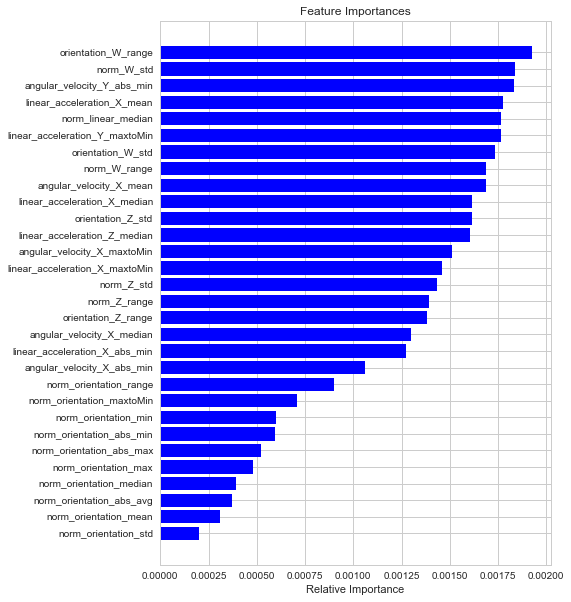

Fold: 3 score: 0.9240837696335078


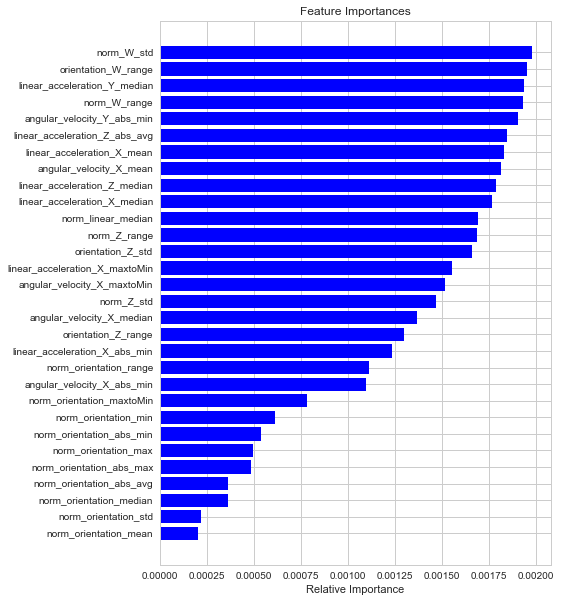

Fold: 4 score: 0.8976377952755905
Fold: 5 score: 0.8976377952755905
Fold: 6 score: 0.931758530183727


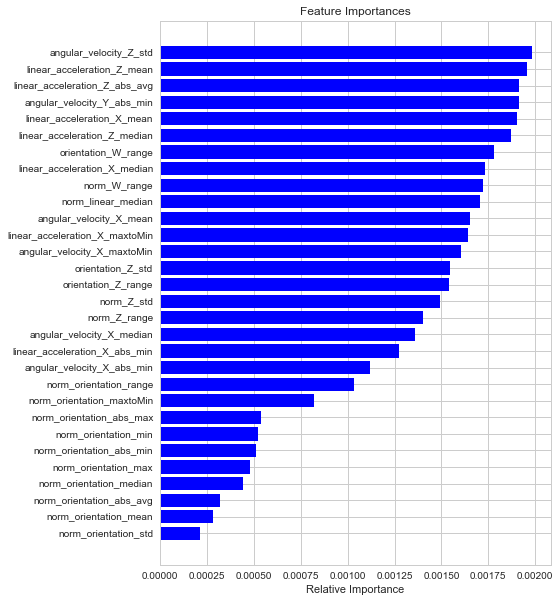

Fold: 7 score: 0.9076517150395779
Fold: 8 score: 0.9021164021164021
Fold: 9 score: 0.9414893617021277


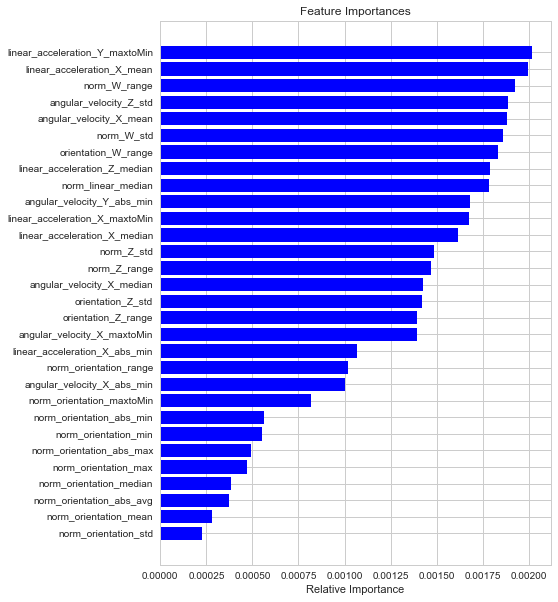

In [33]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)

predicted = np.zeros((test.shape[0],9))
measured= np.zeros((train.shape[0]))
score = 0

for times, (trn_idx, val_idx) in enumerate(folds.split(train.values,target['surface'].values)):
    model = RandomForestClassifier(n_estimators=500, n_jobs = -1)
    model.fit(train.iloc[trn_idx],target['surface'][trn_idx])
    measured[val_idx] = model.predict(train.iloc[val_idx])
    predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(train.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(train.iloc[val_idx],target['surface'][val_idx])))

    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = train.columns
    
    if model.score(train.iloc[val_idx],target['surface'][val_idx]) > 0.92000:
        hm = 30
        plt.figure(figsize=(7, 10))
        plt.title('Feature Importances')
        plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
        plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    gc.collect()

可以看出组合特征占较高的权重。<br>
测试结果在kaggle 上的提交结果为 92%，符合验证结果。

### Summary

- 多分类问题使用随机森林模型往往是不错的选择
- 在没有主特征的情况下，特征提取可以大大提高模型的准确性，但这一步需要一些相关领域的知识，建议多查阅资料和组合的尝试